# Problem setup

Let $X$ be a random variable taking values in $(0, 1]$.
Let $Z$ be a random variable drawn from a geometric distribution with success probability $X$.

If we observe samples of $Z$ can we determine the distribution of $X$?

# Setup sampling

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_cdf(samples):
    plt.plot(np.sort(samples), np.linspace(0, 1, len(samples), endpoint=False));

0.010006389684924316 0.9999566272016625


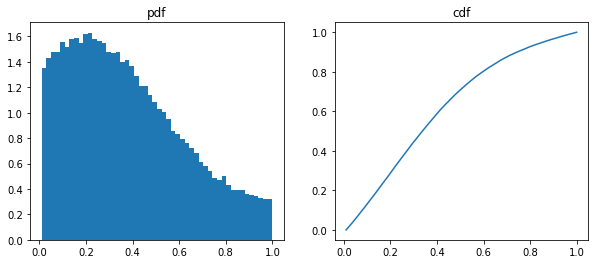

In [3]:
def sample_X(size=(1,)):
    min_x = 0.01

    x1 = np.random.normal(loc=0.2, scale=0.3, size=size)
    x2 = np.random.uniform(low=min_x, high=1, size=size)
    
    ret = x1
    ret[x1 < min_x] = x2[x1 < min_x]
    ret[x1 > 1] = x2[x1 > 1]
    
    return ret

x_samples = sample_X(size=100000)
print(x_samples.min(), x_samples.max())

plt.figure(figsize=(10,4));

plt.subplot(1, 2, 1);
plt.hist(x_samples, density=True, bins=50);
plt.title("pdf");

plt.subplot(1, 2, 2);
plot_cdf(x_samples);
plt.title("cdf");

1 548


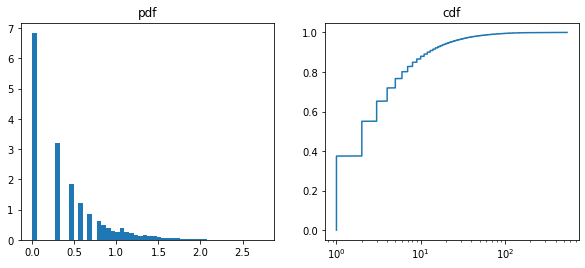

In [4]:
def sample_Z_from_X(x_samples):
    return np.random.geometric(x_samples)

def sample_Z(size=(1,)):
    x_samples = sample_X(size=size)
    return sample_Z_from_X(x_samples)

z_samples = sample_Z(size=100000)
print(z_samples.min(), z_samples.max())

plt.figure(figsize=(10,4));

plt.subplot(1, 2, 1);
plt.hist(np.log10(z_samples), density=True, bins=50);
plt.title("pdf");

plt.subplot(1, 2, 2);
plot_cdf(z_samples);
plt.gca().set_xscale("log");
plt.title("cdf");

# Time for inversion

In [5]:
def geom_int_helper(a, b, n):
    """
    Computes the integral on [a, b] of x^(n - 1) x.
    Calculation from https://www.wolframalpha.com/input/?i=integral+from+a+to+b+of+%281+-+x%29%5E%28n+-+1%29+*+x.
    """
    return (
        (1 - a) ** n * (1 + a * n)
      - (1 - b) ** n * (1 + b * n)
    ) / (n * (1 + n))

def compute_forward_mat(x_bins, max_z):
    ret = np.zeros((max_z, x_bins), dtype=np.float64)
    
    for ix in range(x_bins):
        for iz in range(max_z):
            ret[iz, ix] = geom_int_helper(
                a=ix / x_bins,
                b=(ix+1) / x_bins,
                n=iz + 1
            )
    
    return ret

In [27]:
# How much discretization to do
X_BINS = 64
MAX_Z = 1024

mat_mp = compute_forward_mat(
    x_bins=X_BINS,
    max_z=MAX_Z
)
mat_mp.shape

(1024, 64)

### Testing out forward direction

In [28]:
x_pdf_hat, _ = np.histogram(sample_X(size=100000), bins=np.linspace(0, 1, X_BINS + 1), density=True);
x_pdf_hat.shape, x_pdf_hat.sum() / X_BINS

((64,), 1.0)

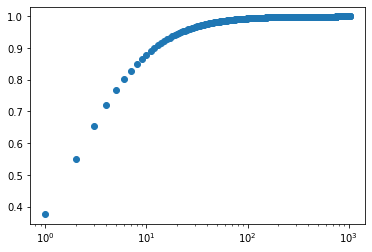

In [29]:
z_pmf_computed = mat_mp @ x_pdf_hat
plt.scatter(np.arange(MAX_Z) + 1, z_pmf_computed.cumsum());
plt.gca().set_xscale("log");

### Backwards direction
(the moment we've been waiting for...)

In [30]:
z_samples = sample_Z(size=100000)
z_pmf_hat = np.bincount(z_samples, minlength=MAX_Z+1)[1:] / len(z_samples)
z_pmf_hat.shape, z_pmf_hat.sum()

((1024,), 1.0)

In [32]:
# Solve for x_pdf where mat_mp @ x_pdf = z_pmf
#x_pdf_computed = np.linalg.solve(mat_mp, z_pmf_hat)
x_pdf_computed = np.linalg.lstsq(mat_mp, z_pmf_hat)[0]
x_pdf_computed.shape

<ipython-input-32-9c47f5e67c96>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_pdf_computed = np.linalg.lstsq(mat_mp, z_pmf_hat)[0]


(64,)

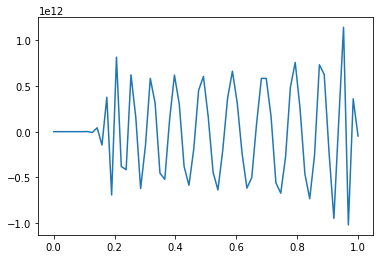

In [35]:
plt.plot(np.linspace(0, 1, X_BINS), x_pdf_computed);

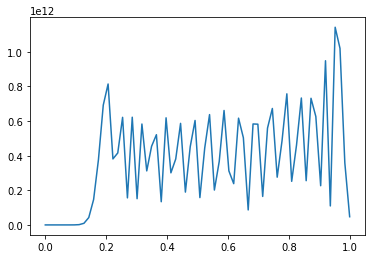

In [34]:
plt.plot(np.linspace(0, 1, X_BINS), np.abs(x_pdf_computed));